### Import modules and read data:

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxc
import numpy as np

In [2]:
G = nx.read_gml('./Graphs/all_data_corr.gml')
nx.info(G)

'Graph with 929 nodes and 5566 edges'

In [15]:
REGION_MAP = {'Northeast': 1, 'South': 2, 'Midwest': 3, 'West': 4}

### Network vis

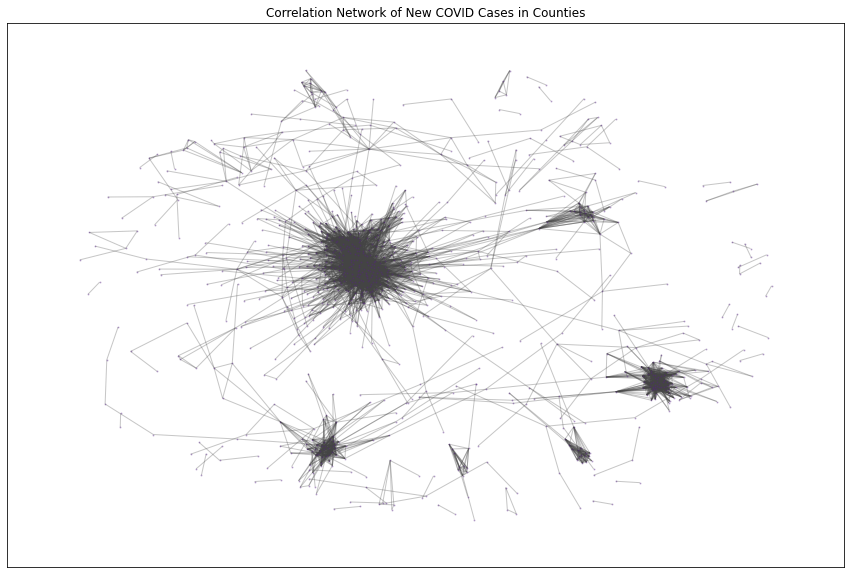

In [3]:
pos = nx.spring_layout(G, k = 0.1, weight = 'weight')

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(G, pos = pos, node_size = 1, node_color = '#552583', edge_color = '#444444', alpha = 0.3, with_labels = False)
plt.title('Correlation Network of New COVID Cases in Counties')
plt.show()
plt.close()

### Community Detection 

In [4]:
def add_node_community(G: nx.Graph, communities: list, label) -> None:
    """Add a marker for the community to the nodes
    Parameters:
        G (nx.Graph): a network
        communities (list): the list of communities
        label (str): the label for the community being added
    Returns:
        None"""
    
    nx.set_node_attributes(G, values = 99, name = label)  # set default value for all nodes
    
    # set specific value for nodes we're interested in
    for i, com in enumerate(communities):
        for c in com:
            G.nodes[c][label] = i + 1

In [5]:
def add_edge_community(G: nx.Graph, label) -> None:
    """Add a marker for the community to the edges
    Parameters:
        G (nx.Graph): a network
        label (str): the label for the community
    Returns:
        None"""
    
    for x, y in G.edges:
        if G.nodes[x][label] == G.nodes[y][label]:  # nodes are in the same community i.e. internal edge
            G.edges[x, y][label] = G.nodes[x][label]
        else:  # external edge
            G.edges[x, y][label] = 0

In [6]:
def get_colour(i, r_off = 1, g_off = 1, b_off = 1) -> (float, float, float):
    """Get colour for a node
    Parameters:
        i (int): community label
        r_off (int): red offset
        g_off (int): green offset
        b_off (int): blue offset
    Returns:
        float: red value
        float: green value
        float: blue value"""
    
    n, low, high = 16, 0.1, 0.9
    span = high - low
    
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)  
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    
    return (r, g, b)

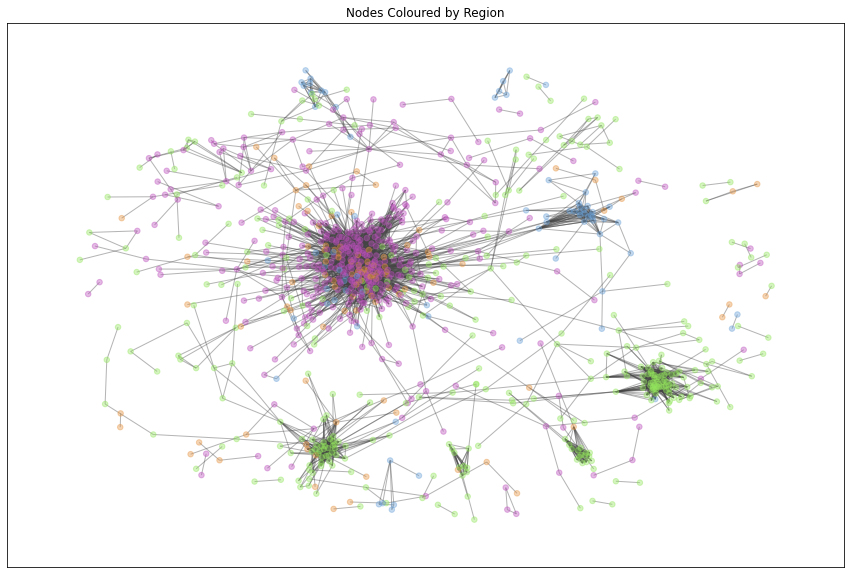

In [17]:
node_colour_region = [get_colour(REGION_MAP[G.nodes[i]['Region']]) for i in G.nodes]

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(G, pos = pos, node_size = 30, node_color = node_colour_region, edge_color = '#444444', alpha = 0.4, with_labels = False)
plt.title('Nodes Coloured by Region')
plt.show()
plt.close()

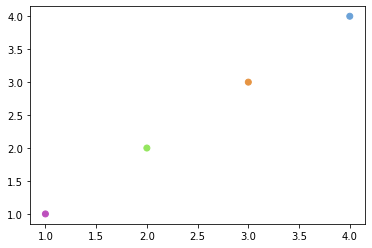

In [21]:
cols = list(set(node_colour_region))
pts_x, pts_y = [i for i in range(1, len(cols) + 1)], [i for i in range(1, len(cols) + 1)]

plt.scatter(pts_x, pts_y, c = cols)
plt.show()
plt.close()

In [27]:
counts = set()
for i in G.nodes:
    if REGION_MAP[G.nodes[i]['Region']] not in counts:
        print(G.nodes[i]['Region'], REGION_MAP[G.nodes[i]['Region']])
        counts.add(REGION_MAP[G.nodes[i]['Region']])
    if len(counts) == 4:
        break

South 2
West 4
Midwest 3
Northeast 1


#### 1. Greedy Modularity Maximisation

In [7]:
gmm_com = nxc.greedy_modularity_communities(G, 'weight')
len(gmm_com)

77

In [8]:
filtered_gmm_com = [c for c in gmm_com if len(c) > 4]
len(filtered_gmm_com)

25

In [9]:
add_node_community(G, filtered_gmm_com, 'gmm')
add_edge_community(G, 'gmm')

In [10]:
external_edges = [(i, j) for i, j in G.edges if G.edges[i, j]['gmm'] == 0]
internal_edges = [(i, j) for i, j in G.edges if G.edges[i, j]['gmm'] > 0]

internal_colour = ['#000000' for _ in internal_edges]
node_colour = [get_colour(G.nodes[i]['gmm']) for i in G.nodes]

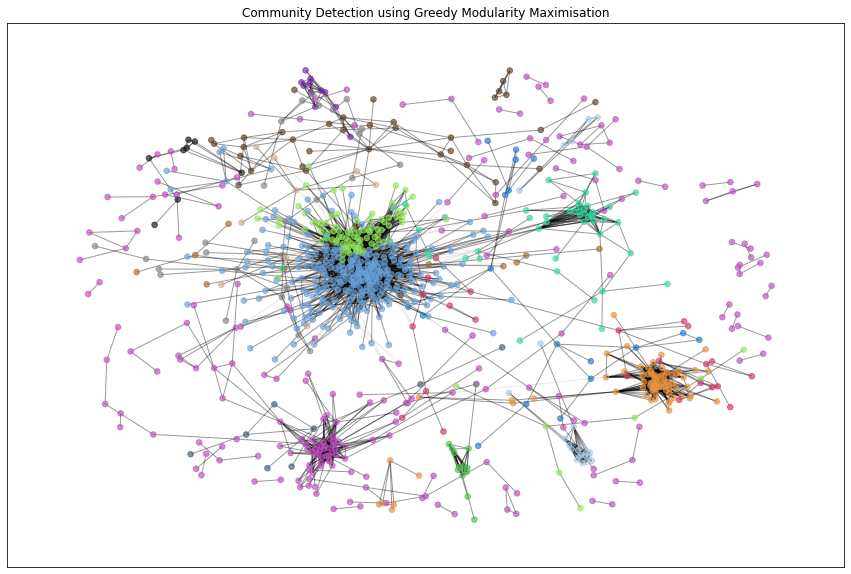

In [11]:
fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(G, pos = pos, node_size = 30, edgelist = external_edges, edge_color = '#cbc1c1', node_color = node_colour, alpha = 0.4, with_labels = False)
nx.draw_networkx(G, pos = pos, node_size = 30, edgelist = internal_edges, edge_color = internal_colour, node_color = node_colour, alpha = 0.4, with_labels = False)
plt.title('Community Detection using Greedy Modularity Maximisation')
plt.show()
plt.close()